In [1]:
import os
import time
import sys
import scipy
import glob
import importlib
import _pickle as pkl
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import trajectory as traj
import plotting as putil
# import shutil
# import scipy.stats as spstats

In [2]:
util.set_sns_style(style='dark', min_fontsize=12)
pl.rcParams['svg.fonttype'] = 'none'
%matplotlib notebook

plot_style = 'white'
util.set_sns_style(style=plot_style)
bg_color = 'k' if plot_style=='white' else 'w' 
boutdir_palette = {'inodor': bg_color, 'inbound': 'c', 'outbound': 'm'}
plot_st = '_yt' if plot_style == 'white' else ''
instrip_palette = {True: 'r', False: 'cornflowerblue'}

In [3]:
# Set source
rootdir = util.get_rootdir()
rootdir = rootdir.split('/Data')[0] #replace('Data', 'All_behavioral_logfiles')
#rootdir = 'google-drive://edge.tracking.ru@gmail.com/1dwuSL3UoUYCxgQXBdMXAjdHDHeSld_L6/Edge_Tracking'
print(rootdir)
src0 = os.path.join(rootdir,'All_behavioral_logfiles') # 'All_constant_all_increasing_gradient')
srcdir = src0
print(srcdir)
# all_logfiles = [f for f in glob.glob(os.path.join(srcdir, '*.log')) if not f.endswith('behavior.log')]
# print(len(all_logfiles))

/home/julianarhee/edgetracking-googledrive/Edge_Tracking
/home/julianarhee/edgetracking-googledrive/Edge_Tracking/All_behavioral_logfiles


In [4]:
# Set dst
dstdir = os.path.join(rootdir, 'Data', 'jyr', 'vertical_strip', 'final')
if not os.path.exists(dstdir):
    os.makedirs(dstdir)
    
figid = 'accepted_logs.csv'

# Create dataframe

In [9]:
create_new = False
combined_datafile = os.path.join(dstdir, 'combined.pkl')
print(combined_datafile)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/vertical_strip/final/combined.pkl


In [10]:
accepted = pd.read_csv(os.path.join(dstdir, 'accepted_logs.csv'))
accepted.shape

(40, 2)

In [11]:
all_logfiles = [os.path.join(srcdir, f['logs']) for i, f in accepted.iterrows()]
print(len(all_logfiles))

40


In [16]:
if not create_new:
    with open(combined_datafile, 'rb') as f:
        df0_all = pkl.load(f, encoding='latin1')
print(df0_all.shape)

(1579395, 42)


In [51]:
plot = False
error_ = []
if create_new:
    d_list = []
    for fp in all_logfiles:
        try:
            parent, fn = os.path.split(fp)
            fname = os.path.splitext(fn)[0]
            # get odor params
            currcond = os.path.split(parent)[-1]
            df0_full, oparams = traj.load_df(fp)
            assert oparams['odor_bounds'] is not None, "Not an odor trial, skipping"
            df0_full['condition'] = currcond
            # add current df
            d_list.append(df0_full)
        except Exception as e:
            error_.append(fp)
            continue
            
        if plot:
            # make dir for trajectory
            curr_figdir = os.path.join(parent, 'trajectories')
            if not os.path.exists(curr_figdir):
                os.makedirs(curr_figdir)
            # plot trajectory
            fig, ax = pl.subplots()
            ax = butil.plot_trajectory(df0_full, ax=ax, odor_bounds=oparams['odor_bounds'], 
                                 zero_odor_start=True)
            ax.set_title(fn, fontsize=8, loc='left')
            ax.set_aspect(1)
            # save
            util.label_figure(fig, '{}'.format(parent.split('/My Drive')[-1]))
            pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fname)), dpi=300)
            pl.close()
    # combine
    df0_all = pd.concat(d_list, axis=0).reset_index()
    # save
    with open(combined_datafile, 'wb') as f:
        pkl.dump(df0_all, f)

/home/julianarhee/Repositories/plume-tracking/behavior.py:1353: RuntimeWarning: divide by zero encountered in divide
  speed = np.linalg.norm(np.array([xv, yv]), axis=0)/tv #avg_tdiff #np.sqrt(xv**2+yv**2)
/home/julianarhee/Repositories/plume-tracking/behavior.py:1357: RuntimeWarning: divide by zero encountered in divide
  df0['upwind_speed'] = yv/tv #avg_tdiff
/home/julianarhee/Repositories/plume-tracking/behavior.py:1358: RuntimeWarning: divide by zero encountered in divide
  df0['crosswind_speed'] = xv/tv #avg_tdiff


In [54]:
print("{} files with errors.".format(len(error_)))
print("Successfully loaded {} logfiles.".format(df0_all['filename'].nunique()))

0 files with errors.
Successfully loaded 40 logfiles.


# Find ET pass

In [69]:
importlib.reload(traj)

<module 'trajectory' from '/home/julianarhee/Repositories/plume-tracking/trajectory.py'>

In [17]:
strip_width=50
strip_sep=1000
# -----------------------------------------------
# Set "ET" parameters
# -----------------------------------------------
max_crossovers = 100 #0
max_instrip_upwind_percent = 1 #0.5
min_outside_bouts = 0 #5
max_crossover_to_dist_ratio= 1 #1/500
min_global_upwind_dist = 0 #400
# -----------------------------------------------
ets=[]
for fn, df_ in df0_all.groupby('filename'):
    odor_bounds = butil.find_strip_borders(df_, 
                                            entry_ix=df_[df_['instrip']].iloc[0].name,
                                            strip_width=strip_width, strip_sep=strip_sep)
    et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(df_,
                                        odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                        max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                        max_crossovers=max_crossovers, 
                                        max_crossover_to_dist_ratio=max_crossover_to_dist_ratio,
                                        min_outside_bouts=min_outside_bouts,
                                        min_global_upwind_dist=min_global_upwind_dist)
    if len(et_bouts)>0:
        ets.append(fn)

aggr_figname = 'ET_max-crossovers-{}_min-outside-bouts-{}_crossoverdist_ratio-{}_min-global-upwind-{}_n{}'\
                .format(max_crossovers, min_outside_bouts, '1per500mm', min_global_upwind_dist, len(ets))
print(aggr_figname)

ET_max-crossovers-100_min-outside-bouts-0_crossoverdist_ratio-1per500mm_min-global-upwind-0_n40


In [18]:

et_id = 'ET_max-crossovers-{}_min-outside-bouts-{}_crossoverdist_ratio-{}_min-global-upwind-{}_n{}'\
                .format(max_crossovers, min_outside_bouts, '1per500mm', min_global_upwind_dist, len(ets))
print(et_id)

ET_max-crossovers-100_min-outside-bouts-0_crossoverdist_ratio-1per500mm_min-global-upwind-0_n40


In [19]:
etdf = df0_all[df0_all['filename'].isin(ets)].copy()
etdf = etdf.reset_index(drop=True)
print("{} of {} were edge-trackers.".format(len(ets), df0_all['filename'].nunique()))

40 of 40 were edge-trackers.


# Plot all ETs

In [21]:
curr_figdir = os.path.join(dstdir, 'ets', 'trajectories')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/vertical_strip/final/ets/trajectories


<IPython.core.display.Javascript object>


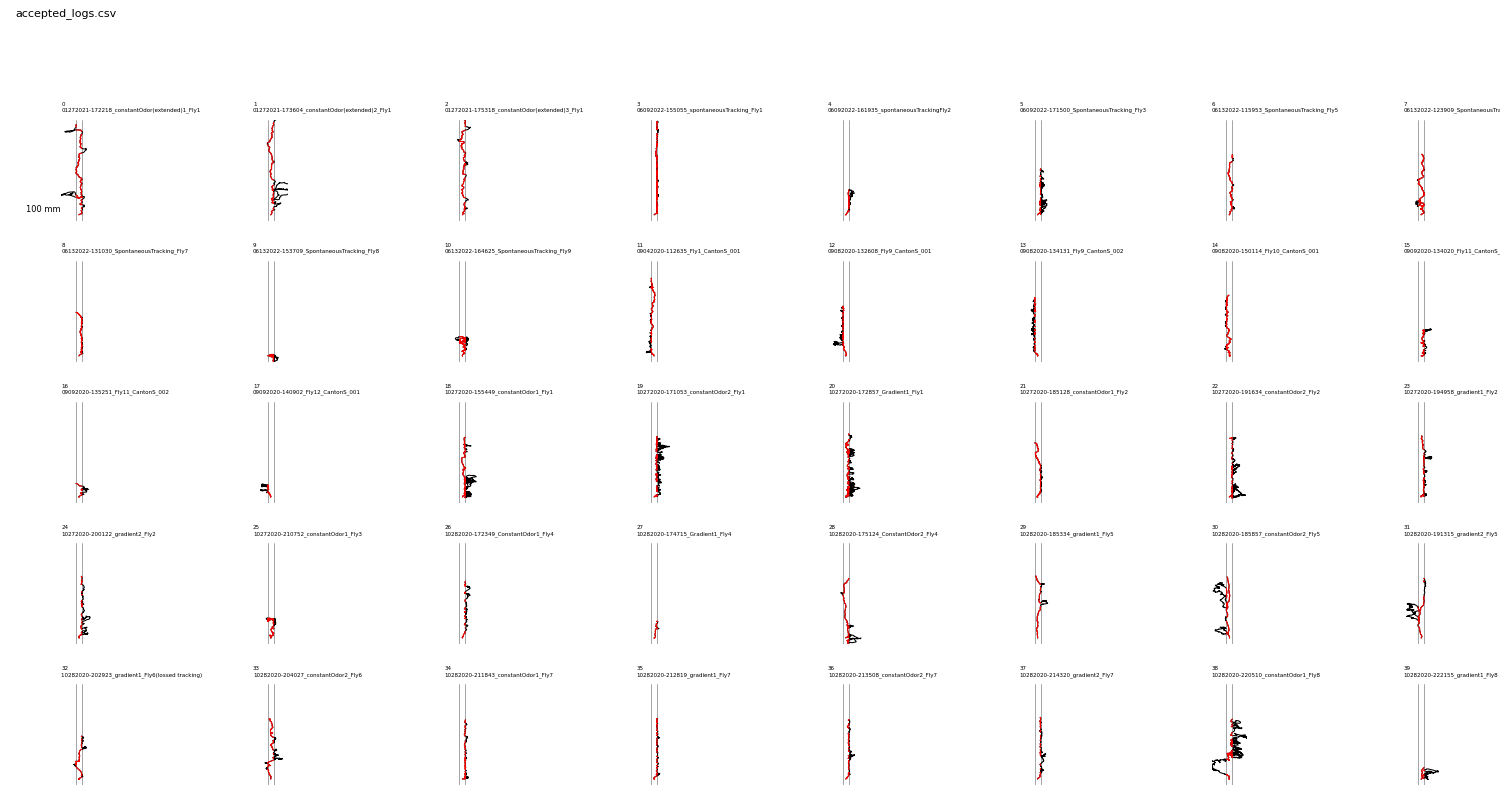

In [20]:
nr=5
nc=8
fig, axn = pl.subplots(nr, nc, figsize=(15,8), sharex=True, sharey=True)
for fi, (fn, df_) in enumerate(etdf.groupby('filename')):
    if fi >= nr*nc:
        break
    ax=axn.flat[fi]
    # PLOT
    last_ = df_[df_['instrip']]['boutnum'].max()
    plotdf = df_[df_['boutnum']<=last_].copy()
    putil.plot_zeroed_trajectory(plotdf, ax=ax, traj_lw=.75, odor_lw=.5,
                                 strip_width=50, strip_sep=1000,
                                 main_col=bg_color, bool_colors=[instrip_palette[True]])
    # legend
    ax.axis('off')
    if fi==0:
        leg_xpos=-150; leg_ypos=0; leg_scale=100
        putil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos)
    #ax.set_box_aspect(3)
    ax.set_xlim([-150, 150])
    ax.set_ylim([-100, 1600])
    ax.set_aspect(0.5)
    ax.set_title('{}\n{}'.format(fi, fn), fontsize=4, loc='left')
    #ax.set_title('{}'.format(fi), fontsize=10, loc='left')
for ax in axn.flat[fi:]:
    ax.axis('off')
pl.tight_layout()
pl.subplots_adjust(top=0.85, hspace=0.4, wspace=0.5) #left=0.1, right=0.9, wspace=1, hspace=1, bottom=0.1, top=0.8)
util.label_figure(fig, figid)
#pl.savefig(os.path.join(curr_figdir, '{}_numbered.png'.format('ALL')))


# Flip all traj to 1 side

In [22]:
d_list=[]
for fn, df_ in etdf.groupby('filename'):
    tmpdf = df_.copy().reset_index(drop=True)
    # odor boundaries
    odor_bounds = butil.find_strip_borders(tmpdf, 
                                        entry_ix=tmpdf[tmpdf['instrip']].iloc[0].name,
                                        strip_width=strip_width, strip_sep=1000)
    # find all ET bouts (in case there is more than 1)
    et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(tmpdf,
                                    odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                    max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                    max_crossovers=max_crossovers, 
                                    max_crossover_to_dist_ratio=max_crossover_to_dist_ratio,
                                    min_outside_bouts=min_outside_bouts,
                                    min_global_upwind_dist=min_global_upwind_dist)
    #et_boutkey = traj.get_best_et_boutkey(et_boutstats)
    # flip trajectory so all riding along strip's right side -- flip WHOLE traj, not just pre LED period
    df_flipped, obounds_fp = butil.check_entryside_and_flip(tmpdf, odor_dict=et_bouts, strip_width=strip_width)
    d_list.append(df_flipped)
df_fp = pd.concat(d_list)

# Zero traj

In [23]:
#del etdf
etdf = df_fp.copy()

In [24]:
d_list=[]
for fn, df_ in etdf.groupby('filename'):
    d_ = butil.process_df(df_)
    d_list.append(d_)
etdf = pd.concat(d_list, axis=0).reset_index(drop=True)

/home/julianarhee/Repositories/plume-tracking/behavior.py:1353: RuntimeWarning: divide by zero encountered in divide
  speed = np.linalg.norm(np.array([xv, yv]), axis=0)/tv #avg_tdiff #np.sqrt(xv**2+yv**2)
/home/julianarhee/Repositories/plume-tracking/behavior.py:1357: RuntimeWarning: divide by zero encountered in divide
  df0['upwind_speed'] = yv/tv #avg_tdiff
/home/julianarhee/Repositories/plume-tracking/behavior.py:1358: RuntimeWarning: divide by zero encountered in divide
  df0['crosswind_speed'] = xv/tv #avg_tdiff


In [25]:
df_z = [putil.zero_trajectory(df_) for fn, df_ in etdf.groupby('filename')]
etdf_zero = pd.concat(df_z).reset_index(drop=True)

midp = strip_width/2
# includd dist_from_edge
etdf_zero['dist_from_edge'] = etdf_zero['ft_posx'] - midp
etdf_zero['dist_from_edge_abs'] = abs(etdf_zero['dist_from_edge'])
etdf_zero.loc[etdf_zero['instrip'], 'dist_from_edge_abs'] = (midp - etdf_zero.loc[etdf_zero['instrip'], 'ft_posx']) 

<IPython.core.display.Javascript object>


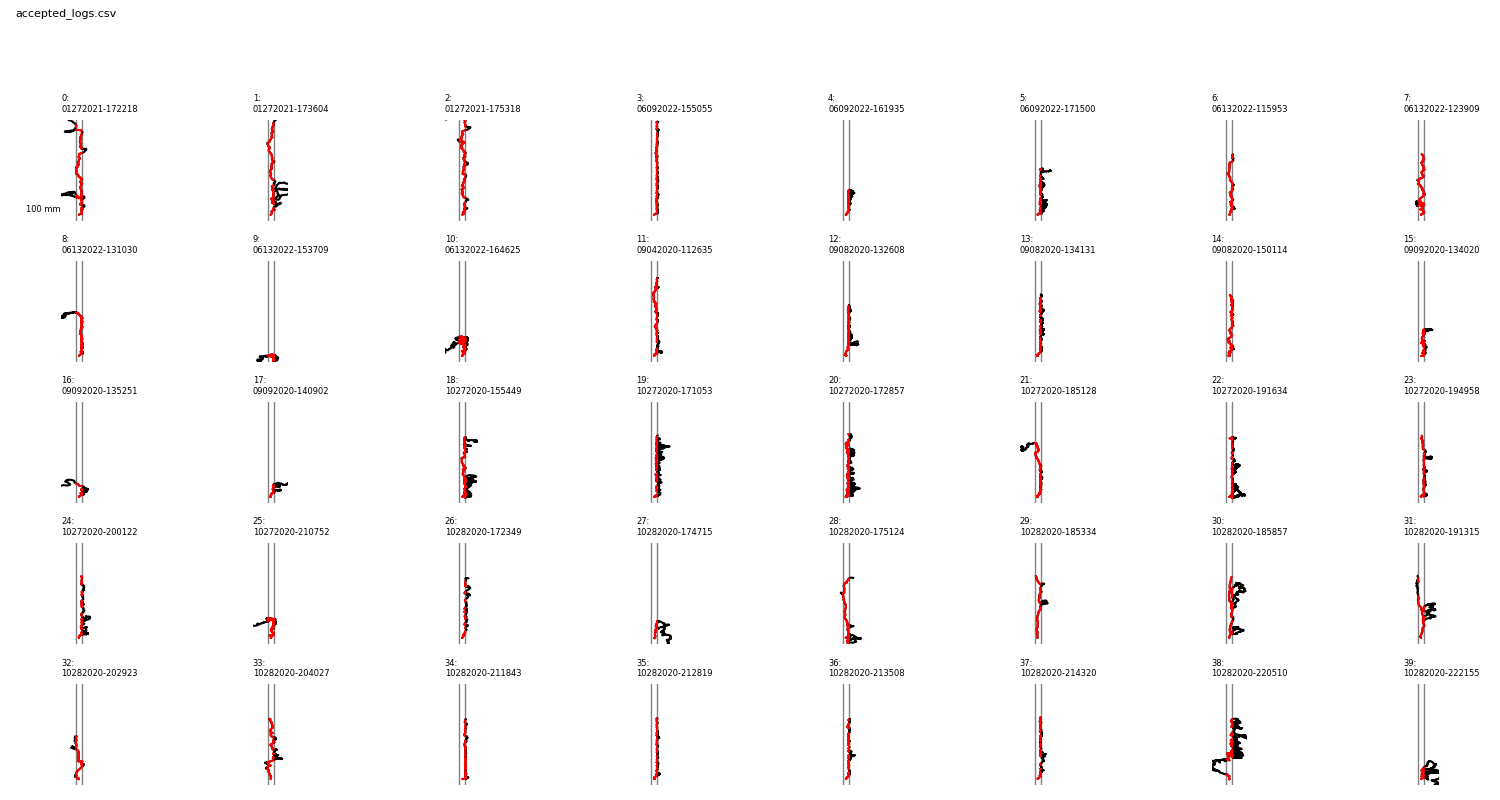

In [26]:
bool_colors=['r']
bool_vars = ['instrip']
fig = putil.plot_array_of_trajectories(etdf, nr=nr, nc=nc, main_col='k', bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id')
util.label_figure(fig, figid)
pl.savefig(os.path.join(curr_figdir, '{}_zeroed.png'.format('ALL')))

# Get  bout metrics

In [27]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [28]:
group_vars=['fly_id', 'filename', 'boutnum', 'condition', 'instrip']
etdf_zero = etdf_zero.reset_index(drop=True)
boutdf = butil.get_bout_metrics(etdf_zero, 
                            group_vars=group_vars) #,numeric=numeric)
boutdf_filt = traj.filter_first_instrip_last_outstrip(boutdf)

# Flip data for plotting

In [29]:
boutdf_filt = putil.flip_data_for_abutting_hists(boutdf_filt)

/home/julianarhee/Repositories/plume-tracking/plotting.py:287: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_boutdf_filt2 = boutdf_filt.groupby(['filename', hue]).median().reset_index()


<IPython.core.display.Javascript object>


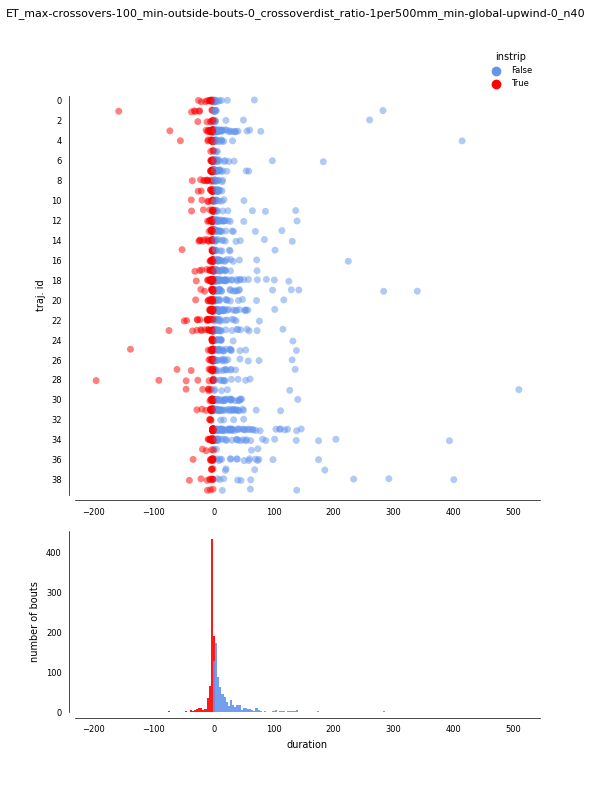

/home/julianarhee/Repositories/plume-tracking/plotting.py:317: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([i if i%2==0 else '' for i, f in enumerate(sorted_by_xwind_out)])


/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/vertical_strip/final/ets/trajectories/ALL_sorted-distn-with-flipped-hist_duration.png


In [31]:
vars_to_flip = ['upwind_speed', 'crosswind_speed', 'duration', 'path_length', 
                'crosswind_dist_range', 
                'upwind_dist_range']

varn =  'duration'# 'path_length_x' #'crosswind_dist_range'

hue_values = [True, False]
hue_colors = [instrip_palette[v] for v in hue_values]

plot_bars = False
errorbar = ('ci', 95)
# for varn in vars_to_flip:
varn_type = 'abs' if 'speed' in varn else 'flipped'

fig = putil.plot_sorted_distn_with_hist(varn, boutdf_filt, varn_type=varn_type,
                                hue_values=hue_values, hue_colors=hue_colors,
                                plot_bars=plot_bars, errorbar=errorbar)
util.label_figure(fig, et_id)
figname = '{}_sorted-distn-with-flipped-hist_{}'.format('ALL', varn)
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
pl.savefig(os.path.join(curr_figdir, '{}.svg'.format(figname)))
print(os.path.join(curr_figdir, '{}.png'.format(figname)))